# Defensive pressure and goal scoring

This notebook investigates *if defensive pressure and defensive players has any impact on the chance of scoring a goal*. If this is the case the next question that will be answered is  *to what extent?*

Rather than just performing some sort of correlation test and draw conclusions from that I build a bunch of expected goal-models based on logistic regression using different sets of predictors or features.

###Data
Data is supplied by Stratagem.

Defensive pressure is a qualititave measure defined by the following examples:

*0 - No defensive players around, nobody blocking the shot*

*1 - Light defensive pressure, no direct tackle but a player stood a few yards away causing some part of the goal to be blocked*

*2 - Low defensive pressure, a player a few yard away but could be sticking a leg out looking to make a block*

*3 - Medium defensive pressure - Close contact with a defender, a player blocking the ball from close range, s player holding onto the shirt but behind the man*

*4 - High defensive pressure - Many defenders crowding around the shooting player, Tackles being made as the shot is taken, very close contact when jumping to meet a header*

*5 - Intense defensive pressure - a player being held while taking a shot, many players all making tackles together giving very little room for a strike, a player crowded out when challenging for a header*

The other data point related to defensive players is *Number of Defensive Players in a DIRECT line of goal from the shooting player*

The data includes all open play shots assisted by a open play pass. This means that shots following crosses or rebounds are excluded. To narrow it down further only shots finished with either foot are included. 



In [160]:
# import necessary modules and activate plotting inline
%matplotlib inline
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mysql.connector
from draw_pitch import draw_pitch
import seaborn as sns
from add_features import calc_angle, calc_distance_to_goal, assist_distance

In [161]:
# get data, decapitalize columns
sql = 'SELECT * FROM stratagem.chances WHERE type = \'open play\' AND bodypart IN (\'right\', \'left\')'

cnx = mysql.connector.connect(user='root', password='anton', host='localhost', database='stratagem')

df = pd.read_sql(sql,cnx)
cnx.close()

for col in df.columns:
    df.rename(columns={col: col.lower()}, inplace=True)

In [162]:
# make numeric columns numeric  
col_to_num = ['location_x', 'location_y', 
              'primarylocation_x', 'primarylocation_y',
              'numdefplayers', 'numattplayers', 'defpressure']

for col in col_to_num:
    df[col] = pd.to_numeric(df[col], errors='coerce')

Below are the original coordinates in the data transformed to meters and transposed to suit a module i have created earlier. Pitch sizes could vary to a small extent but most pitches should be around 68 meters wide and 105 meters long.

In [163]:
# transpose x to y and vice versa
df.rename(columns={'location_x': 'y', 'location_y': 'x',
                   'primarylocation_x':'y2', 'primarylocation_y': 'x2'}, inplace=True)

# convert coords to between 0 - 100
df.y = (df.y + 136)/ (1.36 * 2)
df.x = (df.x) / 4.2

df.y2 = (df.y2 + 136)/ (1.36 * 2)
df.x2 = (df.x2) / 4.2

In [164]:
# convert coords to meters
pitch_width = 68.0
pitch_length = 105.0
goal_size = 7.32

df['x'] = df['x'].apply(lambda x: x*pitch_length/100)
df['y'] = df['y'].apply(lambda x: x*pitch_width/100)

df['x2'] = df['x2'].apply(lambda x: x*pitch_length/100)
df['y2'] = df['y2'].apply(lambda x: x*pitch_width/100)

With the shots converted to meters it is possible to plot them on a pitch with its elements using the previous mentioned draw pitch module.

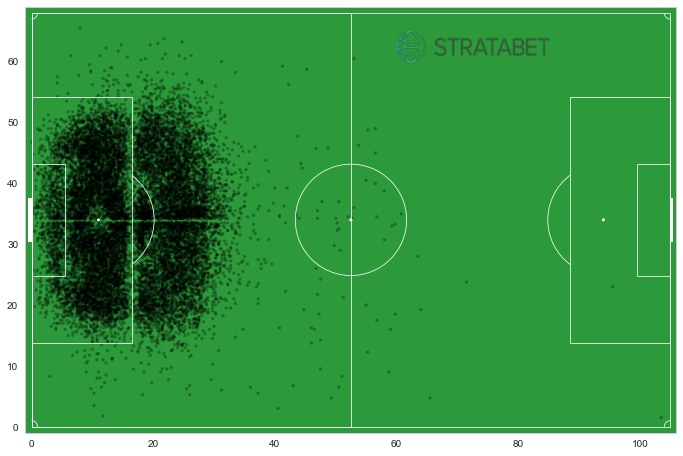

In [165]:
f, ax = plt.subplots(figsize=(pitch_length/9, pitch_length/13))
scatter_plot = plt.scatter(df.x, df.y, edgecolors='None', c='black', s=10, alpha=0.3)
plt.xlim(-1,pitch_length + 1)
plt.ylim(-1,pitch_width+1)
plt.tick_params(top='off', bottom='off', left='off', right='off')
draw_pitch(ax=ax, bg_color='#2c993a')
ax.imshow(plt.imread('data/StrataBet Logo.png'), extent=(60, 85, 60, 65), interpolation='gaussian');

It is a bit hard to get a grasp over the shot distribution with a scatter plot, luckily seaborn is here to help.

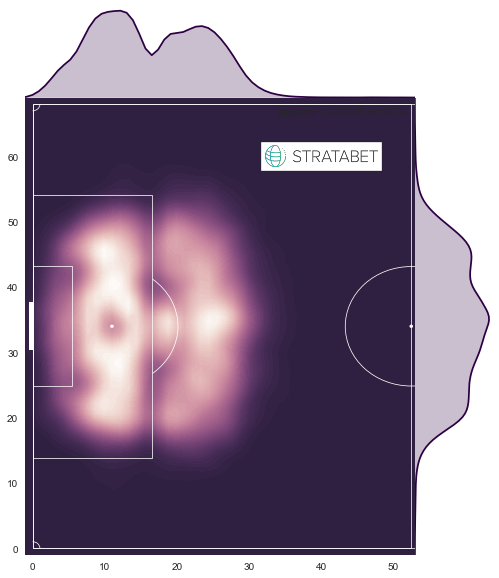

In [166]:
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

sns.set(color_codes=True)
cmap = sns.cubehelix_palette(light=1, as_cmap=True, reverse=True)
jp = sns.jointplot(df.x, df.y, xlim=(-1,pitch_length/2+0.5), ylim=(-1,pitch_width+1), 
                   kind='kde',cmap=cmap, n_levels=60, space=0, color='#2C0042')

jp.fig.set_figwidth(pitch_length/14)
jp.fig.set_figheight(pitch_length/12)


for ax in (jp.ax_marg_x, jp.ax_marg_y):
    ax.grid(False)
    ax.set_facecolor('None')   

draw_pitch(jp.ax_joint)

imagebox = OffsetImage(plt.imread('data/StrataBet Logo.png'), zoom=.3, interpolation='gaussian')

jp.ax_joint.add_artist(AnnotationBbox(imagebox, (40, 60)));

Most shots are taken in and around the penalty area. There is a drop of shots around the penalty area line, which I assume is because of the technique used to collect the data.

### Features
In addition to defensive pressure and number of defensive players _angle_ and _distance_ will be used. These are derived from the coordinates but contains more information than just _x_ and _y_.

*Angle* is the angle between the goal posts and the ball closests to the ball, expressed in degrees. 

*Distance* is the distance from the ball to the goal line anywhere between the posts. It is expressed as the $log(distance + 1)$ rather than just the distance. The rationale behind this is that the chance of scoring likely decreases more between being 3 and 5 meters from the goal than it does between 17 and 19 meters from the goal.

In [167]:
# functions imported from add_features.py
df['angle'] = df.apply(lambda x: calc_angle(x['x'], x['y']), axis=1)
df['distance'] = df.apply(lambda x: calc_distance_to_goal(x['x'], x['y']), axis=1)

In [168]:
# define the predictors
preds = ['angle', 'distance', 'defpressure', 'numdefplayers']

In [169]:
df[preds].describe()[1:]

,angle,distance,defpressure,numdefplayers
mean,22.067340,2.841900,2.090089,2.660314
std,13.981578,0.468748,1.363667,1.308307
min,0.000000,0.223144,0.000000,0.000000
25%,14.400000,2.571722,1.000000,2.000000
50%,17.415000,2.917771,2.000000,2.000000
75%,25.220000,3.213756,3.000000,3.000000
max,171.160000,4.686225,5.000000,11.000000


In [170]:
# map outcome to numbers
df.loc[df['outcome'] <> "-", 'goal'] = 0
df.loc[df['outcome'] == "-", 'goal'] = 1
print 'mean conversion rate:', round(df.goal.mean(), 3)
print 'number of shots:', len(df)

mean conversion rate: 0.116
number of shots: 18626


In [171]:
# features described separated on goal
desc = pd.concat([df[df['goal']== 0][preds].describe()[1:3], df[df['goal']== 1][preds].describe()[1:3]])
desc['goal'] = ['miss', 'miss', 'goal','goal']
desc = desc.pivot(columns='goal')
desc

<div>
<style>
    .dataframe thead tr:only-child th {
        text-align: right;
    }

    .dataframe thead th {
        text-align: left;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr>
      <th></th>
      <th colspan="2" halign="left">angle</th>
      <th colspan="2" halign="left">distance</th>
      <th colspan="2" halign="left">defpressure</th>
      <th colspan="2" halign="left">numdefplayers</th>
    </tr>
    <tr>
      <th>goal</th>
      <th>goal</th>
      <th>miss</th>
      <th>goal</th>
      <th>miss</th>
      <th>goal</th>
      <th>miss</th>
      <th>goal</th>
      <th>miss</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>mean</th>
      <td>35.062862</td>
      <td>20.359917</td>
      <td>2.440682</td>
      <td>2.894614</td>
      <td>1.846047</td>
      <td>2.122153</td>
      <td>1.840499</td>
      <td>2.768025</td>
    </tr>
    <tr>
      <th>std</th>
      <td>24.022744</td>
      <td>10.966910</td>
      <td>0.554626</td>
      <td>0.429262</td>
      <td>1.315202</td>
      <td>1.366711</td>
      <td>1.208965</td>
      <td>1.282459</td>
    </tr>
  </tbody>
</table>
</div>

Goals are generally closer to goal with a bigger angle, less defensive pressure, and fewer defending players between goal and ball.

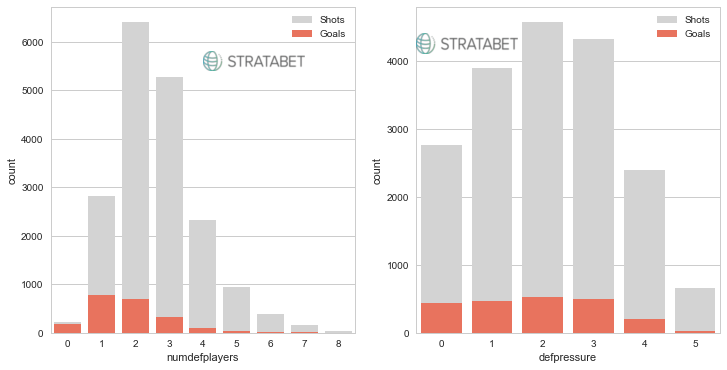

In [218]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

ax[0].imshow(plt.imread('data/StrataBet Logo.png'), extent=(4, 7, 5400, 5800), 
             interpolation='gaussian',aspect='auto')

ax[1].imshow(plt.imread('data/StrataBet Logo.png'), extent=(-.5, 1.5, 4100, 4400), 
             interpolation='gaussian',aspect='auto', zorder=20)

sns.set_style({"axes.grid": 1, 'axes.facecolor': 'white', 'grid.color':'0.4'})
sns.set_style("whitegrid")

sns.countplot(x=df.numdefplayers, ax=ax[0], color='lightgrey', label='Shots')
sns.countplot(x=df[df['goal'] == 1].numdefplayers, ax=ax[0], color='tomato', label='Goals')

sns.countplot(x=df.defpressure, ax=ax[1], color='lightgrey', label='Shots')
sns.countplot(x=df[df['goal'] == 1].defpressure, ax=ax[1], color='tomato', label='Goals')

ax[0].legend()
ax[1].legend();

It is mostly 1 to 4 defensive players between a shot and the goal while most goals are scored with either 1 or 2 defensive players between a shot and the goal.

Goals are better distributed in defensive presure where theere are about the same amount of goals scored for a defensive pressure between 0 and 3. However, fewer shots are taken with 0 defensive pressure.

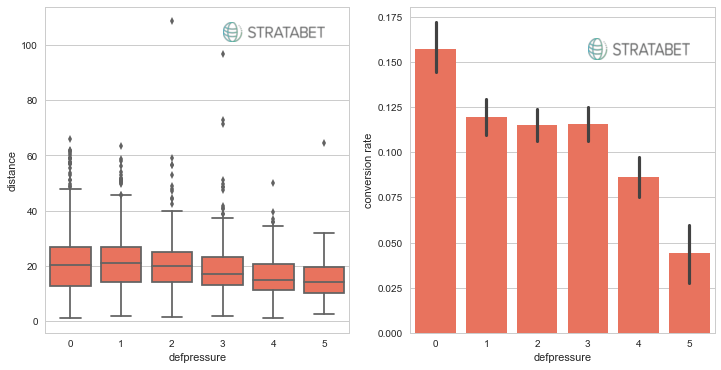

In [173]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))


ax[0].imshow(plt.imread('data/StrataBet Logo.png'), extent=(3, 5, 101, 108), 
             interpolation='gaussian',aspect='auto')

ax[1].imshow(plt.imread('data/StrataBet Logo.png'), extent=(3, 5, 0.151, 0.163), 
             interpolation='gaussian',aspect='auto')

# true distance is plotted
sns.boxplot(x=df.defpressure, y=np.exp(df.distance), ax=ax[0], color='tomato')

sns.barplot(x=df.defpressure, y=df.goal, ax=ax[1], color='tomato')
ax[1].set_ylabel('conversion rate');

The closer a finish is to the goal the more defensive pressure it has. There is no apperant correlation between defensive pressure and conversation rate though. This doesn't mean that defensive pressure is without impact on the goal-scoring rate, but rather that shots with low pressure often are taken further away from goal which decreases the chance of scoring a goal.

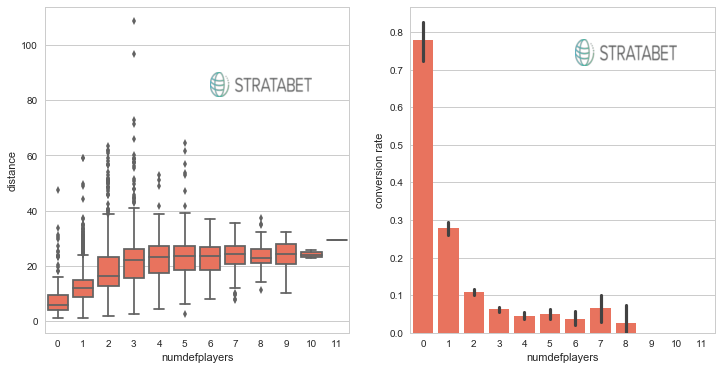

In [174]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

ax[0].imshow(plt.imread('data/StrataBet Logo.png'), extent=(6, 10, 81, 90), 
             interpolation='gaussian',aspect='auto')

ax[1].imshow(plt.imread('data/StrataBet Logo.png'), extent=(6, 10, 0.71, 0.78), 
             interpolation='gaussian',aspect='auto')

# true distance is plotted
sns.boxplot(x=df.numdefplayers, y=np.exp(df.distance), ax=ax[0], color='tomato')
sns.barplot(x=df.numdefplayers, y=df.goal, ax=ax[1], color='tomato')
ax[1].set_ylabel('conversion rate');

The further away from goal the finish is the more defensive players is it possible to squeeze in between the ball and goal. The conversation rate is also higher with fewer defensive players. A little bit surprising here is that fewer than 4 out of 5 shots towards an open goal are scored. 

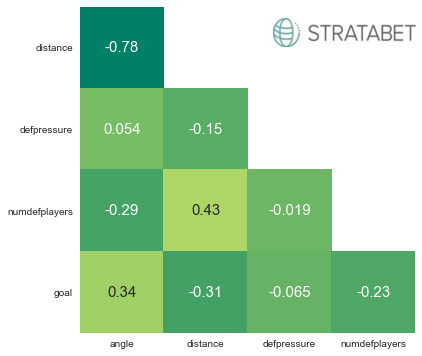

In [175]:
fig, ax = plt.subplots(1, figsize=(6,6))

mask = np.zeros_like(df[preds+['goal']].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(data=df[preds+['goal']].corr(), annot=True, ax=ax, annot_kws={'size':15}, 
            cbar=0, mask=mask, cmap='summer')

plt.xlim(0,4)
plt.ylim(5,1)

ax.imshow(plt.imread('data/StrataBet Logo.png'), extent=(2.3, 4, 1.5, 1.15), 
             interpolation='gaussian',aspect='auto');

The predictors correlate with each other to some extent. The strongest is found between distance and angle which should come as no surprise. 

In [176]:
# import regression modules and extras
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, mean_squared_error, roc_curve, roc_auc_score

# create one matrix for features and one for outcomes
X = np.matrix(df[preds])
y_ = np.array(df['goal'], dtype='int')

# random_state set to some number assures that the random split can be reproduced
x_tr, x_te, y_tr, y_te = train_test_split(X, y_, test_size=0.3, random_state=2017);

The model is trained using all possible combinations of feautures. The intention is to show that the model is performing better with all features included.

Below is a method that will find the best settings for the model, train on the training set, and then return the predictions for the testing set together with what features were used.

In [177]:
# function for training model
# returns tuple with predictions for test set + features model was trained with
def test_features(preds):
    
    X = np.matrix(df[preds])
    y_ = np.array(df['goal'], dtype='int')

    # random_state set to some number assures that the random split can be reproduced
    x_tr, x_te, y_tr, y_te = train_test_split(X, y_, test_size=0.3, random_state=2017);
    
    # use gridsearch to find best parameters
    # gridsearch with full data-set (correct way?)
    GS = GridSearchCV(LogisticRegression(), {'C':[0.1,1,10,100]}, cv=10)
    GS.fit(X, y_)
    
    params = GS.best_params_ 
    
    # train "final" model using training set
    lr = LogisticRegression(C=params['C'])
    
    lr.fit(x_tr, y_tr)
    
    # test model on test set
    pred_test_lr = np.array([x[1] for x in lr.predict_proba(x_te)])
    
    return (preds,  pred_test_lr, params)

In [178]:
# building all possible feature combinations and run the logistic regression with them
import itertools

preds = ['angle', 'distance', 'defpressure', 'numdefplayers']

pred_list = []

for i in range(len(preds)):
    for pred_combo in itertools.combinations(preds, i+1):
        if pred_combo not in pred_list:
            pred_list.append(pred_combo)        

# store results in list of tuples
results = []

for pred in pred_list:
    results.append(test_features(list(pred)))

In [179]:
# the above step took some time, pickle results to avoid having to redo it
import pickle
with open('results_list.pkl', 'wb') as f:
    pickle.dump(results, f)

In [180]:
# read pickle back into results
import pickle
with open('results_list.pkl', 'rb') as f:
    results = pickle.load(f)

### Model evaluation
There are numerous ways but no "correct" of evaluating the performance of a logistic regression model. It comes down to what one are trying the acheive and the "cost" of misclassifying something. 

Three different metrics are used to measure the models' performance.

$RMSE  = \sqrt{\frac{1}{N}\sum_{i=1}^N {(y_i - p_i)^2}} $

$log loss = -\frac{1}{N}\sum_{i=1}^N {(y_i\log(p_i) + (1 - y_i)\log(1 - p_i))}$

Where $p_i$ is the estimated probability and $y_i$ the actual value. These metrics are very similar but the latter penalises being wrong and confident to a bigger extent. It is not possible to say that a model is good if reaches a certain log loss or RMSE score, but by comparing the results to a "model" where all shots where assigned the average scoring rate we can say that the model is better than guessing.

It should be mentioned that it in reality is pointless to use both log loss and RMSE as both of them measure the average error. Model A will never outperform model B with log loss but have a worse RMSE.

*AUC* is an acronym for the area under a [ROC-curve](https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it). It's score is always a number between *0* and *1* where *<0.5* means the model is useless and *1* that it's perfect.



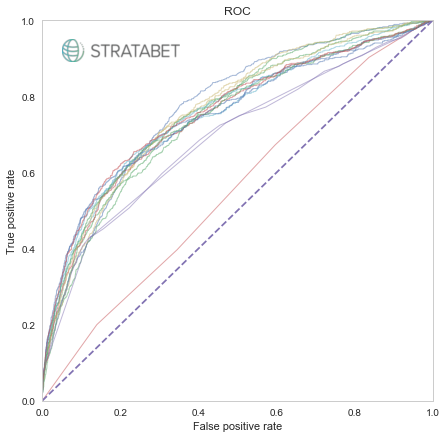

In [181]:
# calculate performance measures from the results and store in df
# plot ROC-curves 
fig, ax = plt.subplots(1, figsize=(7,7))

res_df = pd.DataFrame(index=range(len(results)), columns=['pred', 'auc', 'rmse', 'logloss'])

for i, (p, arr, c)  in enumerate(results):
    fpr, tpr, threshold = roc_curve(y_te, arr)
    ax.plot(fpr, tpr, linewidth=1, alpha=.5)
    res_df.set_value(i, 'pred', (', ').join([x[:2] for x in p])) # first 2 letters of each pred joined to string
    res_df.set_value(i, 'auc', roc_auc_score(y_te, arr)) # area under curve
    res_df.set_value(i, 'rmse', np.sqrt(mean_squared_error(y_te, arr))) # root mean squared error
    res_df.set_value(i, 'logloss', log_loss(y_te, arr)) # log loss
    

ax.imshow(plt.imread('data/StrataBet Logo.png'), extent=(.05, .35, .89, .95), 
             interpolation='gaussian',aspect='auto');

ax.plot((0,1),(0,1), ls='--')
plt.xlim(0,1)
plt.ylim(0,1)
ax.set_ylabel('True positive rate')
ax.set_xlabel('False positive rate')
ax.set_title('ROC')
ax.grid(False);

In [225]:
s = res_df.sort_values(by='auc', ascending=0).astype({'auc':float, 'rmse':float, 'logloss':float}).round(3)
s
#for index, row in s.iterrows():
 #   print '|',row[0],'|', row[1],'|', row[2],'|'

,pred,auc,rmse,logloss
0,an,0.772,0.300,0.312
4,"an, di",0.765,0.299,0.308
10,"an, di, de",0.763,0.297,0.305
14,"an, di, de, nu",0.760,0.293,0.302
11,"an, di, nu",0.757,0.295,0.305
7,"di, de",0.755,0.299,0.308
6,"an, nu",0.751,0.295,0.307
12,"an, de, nu",0.751,0.294,0.305
13,"di, de, nu",0.750,0.296,0.307
1,di,0.749,0.302,0.313


The model using all four features scored best in both AUC and the two error-based metrics. This is evidence enough to say that *Defensive pressure* and *Number of defensive players* have an impact on goalscoring. I would be lying if saying I am surprised by this though. However, I find it interesting that the differences between the models are rather small apart from when just using defensive pressure. 

*Angle* alone outperform a model using the other three together. At first this might look a bit weird but the angle contains a lot of information.

####Differences 
I will study the differences between a model with all four feautures and the model using a only *Angle* and *Distance* a bit more.

In [183]:
# model using all 4 features
lr_all = LogisticRegression(C=results[14][2]['C'])
lr_all.fit(x_tr, y_tr)

# model using angle and distance
lr_ang_dis = LogisticRegression(C=results[4][2]['C'])
lr_ang_dis.fit(x_tr[:,:2], y_tr);

In [184]:
# calculate predictions for all shots in the data and add to df 
pred_all = [x[1] for x in lr_all.predict_proba(X)]
pred_ang_dis = [x[1] for x in lr_ang_dis.predict_proba(X[:,:2])]

df['p_all'] = pred_all
df['p_ang_dis'] = pred_ang_dis
df[['p_all', 'p_ang_dis']].describe()

,p_all,p_ang_dis
count,18626.000000,18626.000000
mean,0.115555,0.115843
std,0.125194,0.110515
min,0.001321,0.009352
25%,0.045652,0.056356
50%,0.075608,0.080591
75%,0.133288,0.126898
max,0.988815,0.984096


The standard deviation is larger for the model using all feutures which was expected and visulised below.

####Prediction density curves
One simple way to show the difference between the two models and their predictions is to plot density curves for the probabilities.

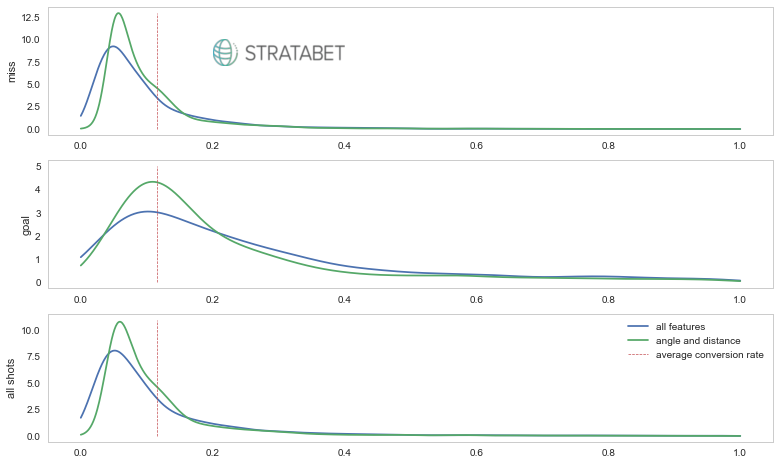

In [213]:
from scipy.stats.kde import gaussian_kde

fig, ax = plt.subplots(3,1, figsize=(13,8))

x = np.linspace(0,1,1000)

ax[0].imshow(plt.imread('data/StrataBet Logo.png'), extent=(.2, .4, 7, 10), 
             interpolation='gaussian',aspect='auto');

ax[0].set_ylabel('miss')
ax[0].plot(x, gaussian_kde(df[df['goal'] == 0]['p_all'])(x), label = 'all features')
ax[0].plot(x, gaussian_kde(df[df['goal'] == 0]['p_ang_dis'])(x), label = 'angle and distance')

ax[1].set_ylabel('goal')
ax[1].plot(x, gaussian_kde(df[df['goal'] == 1]['p_all'])(x), label = 'all features')
ax[1].plot(x, gaussian_kde(df[df['goal'] == 1]['p_ang_dis'])(x), label = 'angle and distance')

ax[2].set_ylabel('all shots')
ax[2].plot(x, gaussian_kde(df['p_all'])(x), label = 'all features')
ax[2].plot(x, gaussian_kde(df['p_ang_dis'])(x), label = 'angle and distance')

for s, h in enumerate([13, 5, 11]):
    ax[s].grid(False)
    ax[s].plot((df.goal.mean(),df.goal.mean()),(0,h), linewidth=0.7, ls='--', label='average conversion rate')
    
ax[2].legend();

 These doesn't say anything about the performance of the models but it is quite clear that the predictions are more evenly spread using all four features.

####Scatter plots
Scatter plots are good to visualise the fit of a data. Instead of grouping by actual teams every shot is assigned one of 100 random teams. 

r2 all features: 0.307778448268
r2 angle, distance: 0.265075474638


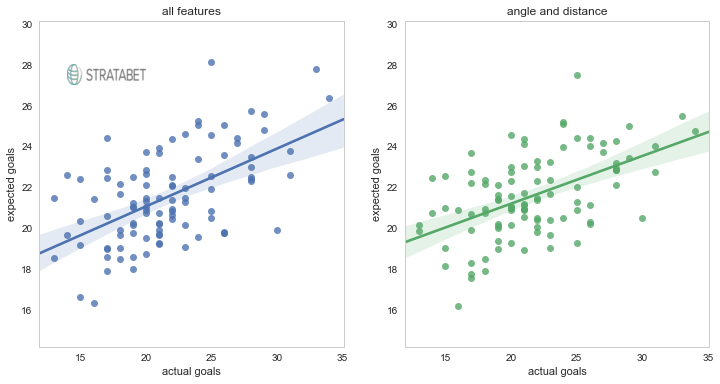

In [186]:
from sklearn.metrics import r2_score

fig, axes = plt.subplots(1,2, figsize = (12,6))

# add random team to df
df['random_team'] = np.random.randint(0, 100, (1,len(df)))[0]
df_random_team = df.groupby(['random_team'], as_index=False).sum()

axes[0].imshow(plt.imread('data/StrataBet Logo.png'), extent=(14, 20, 27, 28), 
             interpolation='gaussian',aspect='auto');

# all features scatter
axes[0].set_title('all features')
sns.regplot(df_random_team.goal, df_random_team.p_all, ax=axes[0])

# angle distance scatter
axes[1].set_title('angle and distance')
sns.regplot(df_random_team.goal, df_random_team.p_ang_dis, ax=axes[1])

for ax in range(2):
    axes[ax].set_ylabel("expected goals")
    axes[ax].set_xlabel("actual goals")
    axes[ax].grid(False)
    axes[ax].set_ylim(min(min(df_random_team.p_ang_dis), min(df_random_team.p_all))-2,
                      max(max(df_random_team.p_ang_dis), max(df_random_team.p_all))+2)
    
print 'r2 all features:', r2_score(df_random_team.goal, df_random_team.p_all)
print 'r2 angle, distance:', r2_score(df_random_team.goal, df_random_team.p_ang_dis)

Visually they look very similar. The all feautures model have somewhat better score but far from impressive. One way to drastically improve the score would be to group by actual teams instead.

#### Quantifying impact on goalscoring
The models coeffecients and intercept give away all the information one need to put a number on the impact.

In [187]:
for p, c in zip(lr_all.coef_[0], preds):
    print c, "coeff:", p
print 'intercept:', lr_ang_dis.intercept_[0]

angle coeff: 0.0225292182934
distance coeff: -0.732014431227
defpressure coeff: -0.16982145269
numdefplayers coeff: -0.471176381289
intercept: 0.226466341352


These are used in the equtions below to calculate the probility of a shot being a goal

$y = β_0 + angle * β_1 + distance * β_2 + defpressure * β_3 + numdefplayers * β_4$

$xG = \frac{1}{1+e^{-y}}$

This is nothing that needs to be done manually as it is exactly what ``LogisticRegression.predict_proba()`` does.

Below is a chart that shows how goal probability varys with number of defenders and defensive pressure with a shot being taken right in front of goal at the line of the penalty area.

xg for non defensive model: 0.0988692012179


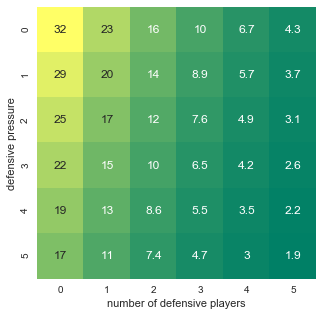

In [223]:
fig, ax = plt.subplots(figsize=(5,5))

x = 16.5
y = pitch_width/2

angle = calc_angle(x,y)
distance = calc_distance_to_goal(x,y)

# combos of defensive players and defensive pressure
combos = list(itertools.product(range(0,6), range(0,6)))
matrix = np.zeros((6,6))

for defpress, numdef in combos:
    p = lr_all.predict_proba([[angle, distance, defpress, numdef]])[0][1]
    matrix[defpress, numdef] = p*100
    
print 'xg for non defensive model:', (lr_ang_dis.predict_proba([[angle, distance]])[0][1])

sns.heatmap(matrix, annot=True, cbar=0, ax=ax, cmap='summer')
ax.set_ylabel('defensive pressure')
ax.set_xlabel('number of defensive players');

With no defensive pressure and no players there is according to the model 30 % chance of scoring. With 3 in defensive pressure and 2 players between the ball and goal the probability has decreased to 10 % - this is the same as the model without defensive value would assign this shot.

Another way to visualise the impact is plotting the xG-threshold on a pitch for different defensive values.

In [188]:
def get_xg_threshold(prob_search, in_numdef, in_defpress, resolution=1000):
    
    # upper and lower y-threshold
    upper = []
    lower = []
    
    # find upper and lower y threshold for every x
    for x in np.linspace(0, pitch_length/2, resolution):
        # list to store all probs in y-range
        temp_list = []
        y_range = np.linspace(0, int(pitch_width), resolution)
        
        for y in y_range:        
            # calc stuff
            angle = calc_angle(x, y)
            dist = calc_distance_to_goal(x, y)
            prob = lr_all.predict_proba(np.matrix([angle, dist, in_defpress, in_numdef]))[0][1]
        
            temp_list.append(prob)
            
        probs_arr = np.array(temp_list)
        
        # if no probability in y-range < threshold, go to next y-range
        if probs_arr.min() > prob_search:
            continue
        
        # if max probability in y_range < threshold, return x and y for threshold line
        elif probs_arr.max() < prob_search:
            x_coords = zip(*upper)[0] + zip(*lower)[0][::-1] 
            y_coords = zip(*upper)[1] + zip(*lower)[1][::-1]
            return (x_coords, y_coords)
        
        # if threshold is within y-range, return y coordinates closest to threshold
        # there will always be and upper and lower threshold if it exists
        else:
            l_arr, u_arr = np.split(probs_arr, 2, axis=0)    
            
            l_idx = np.abs(l_arr - prob_search).argmin()
            u_idx = np.abs(u_arr - prob_search).argmin()
            
            lower.append((x, y_range[l_idx]))
            upper.append((x, y_range[u_idx + resolution/2]))

In [189]:
# calculate thresholds for all combos of defpress < 6 and numde < 7 for xG 10 %
# stor in dict with (defpress, numdef) as key
#thresholds = {}

#for defpress, numdef in list(itertools.product(range(6), range(7))):
 #   p = get_xg_threshold(prob_search=0.1, in_numdef=numdef, in_defpress=defpress)
  #  thresholds[(defpress, numdef)] = p

In [191]:
# took some time, pickle tresholds
#with open('threshold_dict.pkl', 'wb') as f:
 #   pickle.dump(thresholds, f)

In [192]:
with open('threshold_dict.pkl', 'rb') as f:
    thresholds = pickle.load(f)

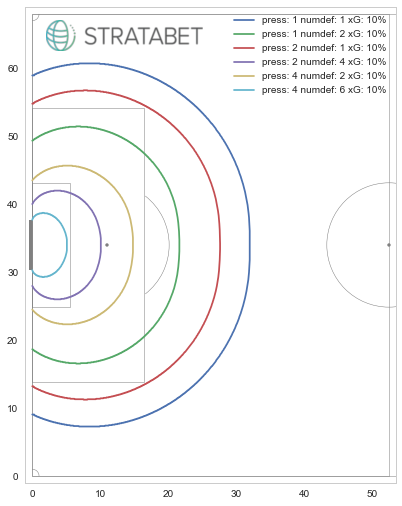

In [193]:
f, ax = plt.subplots(figsize=(pitch_length, pitch_length/12))
plt.xlim(-1,pitch_length/2+1)
plt.ylim(-1,pitch_width+1)

draw_pitch(ax, lw=0.5, bg_color='white', color='grey')

# plot thresholds
#for (defpress, numdef), t in thresholds.iteritems():
for d in [(1,1), (1,2), (2,1), (2,4), (4,2), (4,6)]:    
    if thresholds[d] is not None:
        x, y = thresholds[d]
        ax.plot(x, y, label='press: '+ str(d[0]) + ' numdef: ' + str(d[1]) + ' xG: 10%')
        
ax.imshow(plt.imread('data/StrataBet Logo.png'), extent=(2, 25, 62.5, 67), interpolation='gaussian')
ax.legend();

The innermost ring represents where inside a shot has to be taken to have an xG-value of 10% or more if the number of defensie players are 6 and the defensive pressure is at 4. The outermost ring has the same xG-value but with 1 defensive player and 1 in defensive pressure.

In [224]:
# # for gif
# print df[(df['gsm_id'] == 2380300) & (df['player'] == 'O. Eddahri') 
#          & (df['icon']== 'goal')][['p_ang_dis', 'p_all', 'numdefplayers']]
# print df[(df['gsm_id'] == 2380316) & (df['player'] == 'Paulinho Guerreiro') 
#          & (df['icon']== 'goal')][['p_ang_dis', 'p_all', 'numdefplayers']]
# print df[(df['gsm_id'] == 2380295) & (df['player'] == 'A. Badji')][['p_ang_dis', 'p_all', 'numdefplayers']]

**This article was written with the aid of StrataData, which is property of [Stratagem Technologies](http://www.stratagem.co). StrataData powers the [StrataBet](http://www.stratabet.com) Sports Trading Platform, in addition to [StrataBet Premium Recommendations](http://app.stratabet.com/recommendations).**